# Analyse quantitative multibranche

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib_venn import venn3_unweighted, venn3

On charge les données d'un fichier exporté du système de gestion des branches RHD.

In [2]:
path = Path('..') / 'data' / 'export2020.csv'

types = {
    'material': 'object', 
    'branch': 'int',
    'plant': 'object',     
    'type': 'object',
    'designation': 'object',
    'del_mand': 'bool', 
    'del_plant': 'bool',
    'march_group': 'object', 
    'storage_cond': 'object',
    'hier': 'object',
}
df = pd.read_csv(path,
                 sep=';',
                 encoding='latin-1',
                 engine='python',
                 header=0,
                 skipfooter=1, # footer line with totals in export
                 dtype=types,
                 true_values=['X'], # for del_mand and del_plant
                 false_values=['', np.nan], # for del_mand and del_plant
                )
df = df[types.keys()] #filter and reorder columns

Parmi les colonnes conservées, on a : 
- le code article (material)
- le code de branche de création (branch).
  - 1: PassionFroid
  - 2: EpiSaveurs
  - 3: TerreAzur
- le code d'activation sur une branche (plant).
  - 1PPF: PassionFroid
  - 2PES: EpiSaveurs
  - 3PTA: TerreAzur
- le type d'article (type).
  - ZNEG: Négoce
  - ZPRE: Prestation
- le libellé de l'article (designation)
- si l'article est marqué pour suppression pour toutes les branches (del_mand)
- si l'article est marqué pour suppression sur la branche mentionnée dans la colonne plant (del_plant).
- le groupe de marchandises (march_group) :
  - ZSURGE: Surgelés
  - ZFRAIS: Frais (PassionFroid)
  - ZEPI: Epicerie
  - ZBOI: Boissons
  - ZHYG: Hygiène et chimie
  - ZFLF: Fruits et légumes (TerreAzur)
  - ZFP: Fleurs et plantes
  - ZELAB: Produits élaborés (TerreAzur)
- la condition de stockage (storage_cond) :
  - FR: Frais (PassionFroid)
  - SU: Surgelé,
  - EP: Epicerie,
  - AL: Alcool
  - HY: Hygiène et chimie
  - FL: Fruits et légumes (TerreAzur)
  - FP: Fleurs et plantes
  - MA: Marée
  - SA: Saurisserie (produits élaborés de la mer)
  - SE: Articles de Service
  - PL: Articles de publicité
- la hiérarchie produit (hier). Un plan de classement sur 6 niveaux, représentés par 2 caractères numériques chacun.

In [3]:
df.loc[[5000, 90000, 100000, 130000, 110000] , :]

,material,branch,plant,type,designation,del_mand,del_plant,march_group,storage_cond,hier
5000,15712,2,2PES,ZNEG,PSVNX CERN BRISURE S/AZ SAC 1KGX12 CERNO,True,True,ZEPI,EP,832020500505
90000,153086,3,3PTA,ZNEG,MANGUE KENT 351/550G PAD 12F DELIC BR°,False,False,ZFLF,FL,920518010405
100000,165387,1,1PPF,ZNEG,SALADE PLT 1KGX12 HAMAL,False,False,ZFRAIS,FR,202520150505
130000,203582,1,1PPF,ZPRE,EFFILOCHE BOEUF BARBACOA (2KGX6)/12KG CS,False,False,ZSURGE,SU,401015051505
110000,177238,2,2PES,ZNEG,COMP POIRE ALL BIO BTE 5/1X3 STM,False,False,ZEPI,EP,832005451505


On peut calculer la volumétrie d'articles et la représenter comme un histogramme :

In [4]:
counts = df.groupby('plant')['material'].count().rename('Total')
filtered_counts = df[~df.del_mand & ~df.del_plant].groupby('plant')['material'].count().rename('Actifs')
report = pd.concat([counts, filtered_counts], axis=1)
report.loc['Délice et Création', :] = [10000, 10000]
report.loc['Saveurs d\'Antoine', :] = [12000, 12000]
report.rename({'1PPF': 'PassionFroid', 
               '2PES': 'EpiSaveurs',
               '3PTA': 'TerreAzur'}, 
              inplace=True)
report

,Total,Actifs
plant,,
PassionFroid,48478.0,24898.0
EpiSaveurs,22498.0,12798.0
TerreAzur,73804.0,62789.0
Délice et Création,10000.0,10000.0
Saveurs d'Antoine,12000.0,12000.0


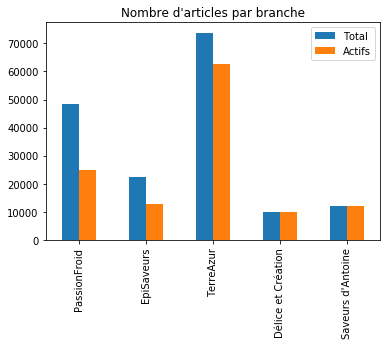

In [5]:
fig, ax = plt.subplots()
report.plot(kind='bar', ax=ax)
ax.set_title('Nombre d\'articles par branche')
ax.set_xlabel('')
fig.savefig(Path('..') / 'img' / 'Articles par branche.png', bbox_inches='tight')

On peut également contruire le diagramme de Venn des articles pour les branches RHD :

In [6]:
branch_sets = [set(df.loc[df.plant == branch_, 'material']) for branch_ in ['1PPF', '2PES', '3PTA']]
filtered_df = df.loc[~df.del_mand & ~df.del_plant]
filtered_sets = [set(filtered_df.loc[filtered_df.plant == branch_, 'material']) for branch_ in ['1PPF', '2PES', '3PTA']]

In [7]:
def labelize(ax, label, where='bottom', **kwargs):
    ax.set_axis_on()
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(False)
        if where == 'bottom':
            ax.set_xlabel(label, **kwargs)
        elif where == 'left':
            ax.set_ylabel(label, **kwargs)
        else:
            raise ValueError(f"Unexpected 'where' argument: {where}")

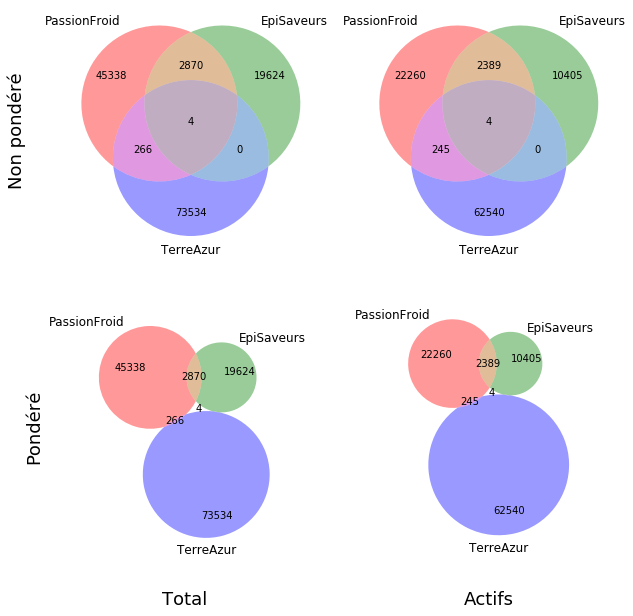

In [8]:
fig, axs = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 10))
scope = ['Total', 'Actifs']
types = ['Non pondéré', 'Pondéré']
for col, source_df in enumerate([branch_sets, filtered_sets]):
    for row, venn_kind in enumerate([venn3_unweighted, venn3]):        
        venn_kind(source_df, set_labels=['PassionFroid', 'EpiSaveurs', 'TerreAzur'], ax=axs[row, col])
        if col == 0: 
            labelize(axs[row, col], types[row], where='left', fontsize=18, labelpad=40)
        if row == 1: 
            labelize(axs[row, col], scope[col], where='bottom', fontsize=18, labelpad=40)
fig.savefig(Path('..') / 'img' / 'Diagrammes de Venn articles.png', bbox_inches='tight')
